We can directly utilize a tensor for training if the training dataset is short and can be loaded into memory. In common usage cases, when the dataset is too huge to fit in computer memory, we must load the data from the primary storage device batch by batch. To prevent overfitting, we may need to build a data-processing pipeline to perform transformations and preprocessing processes to our data, such as mean centering, scaling, or introducing noise.

Manually applying preprocessing functions is tedious. PyTorch has a class for building efficient preprocessing pipelines. In this section, we'll explore how to create a PyTorch `Dataset` and `DataLoader` and load, shuffle, and batch data. PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset.

In [11]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from fastai.vision.all import *

In [2]:
# This patch is to display epoch results while using Visual Studio Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# Dataset

We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides `torch.utils.data.Dataset` that allow you to use your own data. Dataset stores the samples and their corresponding labels to enable easy access to the samples.

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
- The `__init__` function is run once when instantiating the Dataset object.
- The `__len__` function returns the number of samples in our dataset.
- The `__getitem__` function loads and returns a sample from the dataset at the given index idx.

In [4]:
class ToyData(Dataset):
    """This class will generate a toy dataset of given length.
    Each data will have 2 features and a corresponding label. 
    """
    def __init__(self, length = 100, transform = None):
        self.len = length
        self.x = 2 * torch.ones(length, 2)
        self.y = torch.ones(length, 1)
        self.transform = transform
     
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)     
        return sample

    def __len__(self):
        return self.len

We are able to customize the indexing and length method by customizing <code>def \__getitem\_\_(self, index)</code> and <code>def \__len\_\_(self)</code>. As a result, we can apply the same indexing convention as a <code>list</code>, and apply the fuction <code>len</code> on the <code>ToyData</code> object.

In [5]:
dataset = ToyData(length=100)
for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  1 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  2 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  3 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  4 ; x: tensor([2., 2.]) ; y: tensor([1.])


In [6]:
len(dataset)

100

The dataset object is an Iterable; as a result, we  apply the loop directly on the dataset object.

In [13]:
for x, y in dataset:
    print(' x:', x, 'y:', y)

 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 

# Transforms
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. You can also create a class for transforming the data. In this case, we will try to add 1 to our features and multiply our labels by 2.

In [7]:
class CustomTransforms(object):
    def __init__(self, addx = 1, muly = 2):
        self.addx = addx
        self.muly = muly

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        x = x + self.addx
        y = y * self.muly
        sample = x, y
        return sample

We can apply the transform object every time we create a new <code>ToyData</code>.


In [8]:
transform = CustomTransforms()
dataset = ToyData(length=100, transform=transform)

for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  1 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  2 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  3 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  4 ; x: tensor([3., 3.]) ; y: tensor([2.])


# Compose
`Compose` composes several transforms together. For example, we have splitted the previous transformation into two separate classes. The `FeatureTransformer` adds `1` to all the features. On the other hand the `LabelTransformer` multiplies the labels by `2`.

In [9]:
class FeatureTransforms(object):
    def __init__(self, addx = 1):
        self.addx = addx

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        x = x + self.addx
        sample = x, y
        return sample


class LabelTransforms(object):
    def __init__(self, muly = 2):
        self.muly = muly

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        y = y * self.muly
        sample = x, y
        return sample

In [10]:
transform = transforms.Compose([FeatureTransforms(), LabelTransforms()])
dataset = ToyData(transform=transform)

for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  1 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  2 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  3 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  4 ; x: tensor([3., 3.]) ; y: tensor([2.])


# DataLoader
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

A `DataLoader` can take any Python collection and turn it into an iterator over many batches.

In [12]:
data = range(15)
dl = DataLoader(data, batch_size=5, shuffle=True)
list(dl)

[tensor([ 4, 13,  9, 10,  5]),
 tensor([ 0,  7,  2,  8, 14]),
 tensor([ 3, 12,  1, 11,  6])]

However, for training deep learning models, we need batches of features and labels. A collection that contains tuples of features and corresponding labels are called `Dataset`.

In [13]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing batches of features and labels.

In [14]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([21,  6, 15, 11, 10, 18]), ('v', 'g', 'p', 'l', 'k', 's')),
 (tensor([25, 23, 12,  8, 17, 16]), ('z', 'x', 'm', 'i', 'r', 'q')),
 (tensor([ 2,  7,  9,  1,  0, 19]), ('c', 'h', 'j', 'b', 'a', 't')),
 (tensor([ 4, 20, 22, 14,  3, 13]), ('e', 'u', 'w', 'o', 'd', 'n')),
 (tensor([24,  5]), ('y', 'f'))]

Let's create a `DataLoader` for our dataset.

In [15]:
trainloader = DataLoader(dataset=dataset, batch_size=50, shuffle=True)

for data in trainloader:
    print('Mini-batch feature shape:', data[0].shape)
    print('Mini-batch label shape:', data[1].shape)

Mini-batch feature shape: torch.Size([50, 2])
Mini-batch label shape: torch.Size([50, 1])
Mini-batch feature shape: torch.Size([50, 2])
Mini-batch label shape: torch.Size([50, 1])


# Putting it Altogether

Now we will create our custom `Dataset` object to load our custom dataset.

In [16]:
directory = "res/datasets/mnist_sample"

In [17]:
split = 'train'
for path in os.listdir(os.path.join(directory, split)):
    print(path)

3
7


In [21]:
class MNISTSample(Dataset):
    def __init__(self, data_dir, split='train', transform=None, label_transform=None):
        self.dir = data_dir
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.label_transform = label_transform

        self.paths = []
        self.labels = []
        self.len = 0

        for subdir in os.listdir(self.data_dir):
            data_subdir = os.path.join(self.data_dir, subdir)
            for file in os.listdir(data_subdir):
                self.paths.append(os.path.join(data_subdir, file))
                self.labels.append(subdir)
                self.len += 1

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img_name = self.paths[idx]
        image = Image.open(img_name)    
        y = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            y = self.label_transform(y)

        return image, y

In [22]:
dataset = MNISTSample(directory)

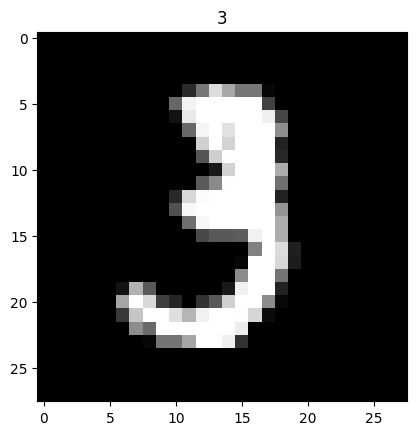

In [23]:
plt.imshow(dataset[0][0], cmap='gray')
plt.title(dataset[0][1])
plt.show()

The torchvision.transforms module offers several commonly-used transforms out of the box. For example, The features are in PIL Image format. For training, we need the features as normalized tensors. To make these transformations, we use the built-in `ToTensor` transformation.

In [24]:
croptensor_data_transform = transforms.Compose([transforms.CenterCrop(20), transforms.ToTensor()])
dataset = MNISTSample(directory, transform=croptensor_data_transform)

In [25]:
dataset[0][0].shape

torch.Size([1, 20, 20])

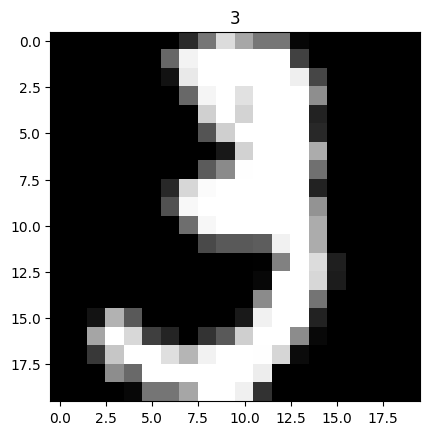

In [26]:
plt.imshow(dataset[0][0].squeeze(0), cmap='gray')
plt.title(dataset[0][1])
plt.show()

In [28]:
trainloader = DataLoader(dataset, shuffle=True, batch_size=20)
len(list(trainloader))

620

# Augmentation

In [29]:
random_crop = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.05, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

random_rotation = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

random_flip = transformations = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

random_grayscale = transforms.Compose([
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

random_blur = transforms.Compose([
    transforms.GaussianBlur((5, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

In [30]:
dataset = MNISTSample(directory, transform=transforms.ToTensor())
augmented_random_crop = MNISTSample(directory, transform=random_crop)
augmented_color_jitter = MNISTSample(directory, transform=color_jitter)
augmented_random_rotation = MNISTSample(directory, transform=random_rotation)
augmented_random_flip = MNISTSample(directory, transform=random_flip)
augmented_random_grayscale = MNISTSample(directory, transform=random_grayscale)
augmented_random_blur = MNISTSample(directory, transform=random_blur)

final_dataset = torch.utils.data.ConcatDataset([
    dataset,
    augmented_random_crop,
    augmented_color_jitter,
    augmented_random_rotation,
    augmented_random_flip,
    augmented_random_grayscale,
    augmented_random_blur
])
trainloader = DataLoader(final_dataset, shuffle=True, batch_size=20)
len(list(trainloader))

4339

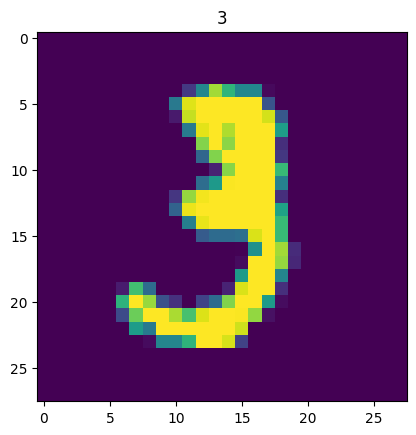

In [31]:
plt.imshow(dataset[0][0].squeeze(0))
plt.title(dataset[0][1])
plt.show()

# Fastai Way

We will first download the Oxford-IIIT Pets dataset. You can find documentations on all the available `fastai` datasets [here](https://docs.fast.ai/data.external.html#main-datasets).

In [32]:
path = untar_data(URLs.PETS)

In [33]:
path.ls()

(#2) [Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/musab/.fastai/data/oxford-iiit-pet/images')]

The `get_image_files` from `fastai` library fetches all the image files of the given path recursively.

In [34]:
files = get_image_files(path / 'images')
len(files)

7390

In [36]:
for file in files[0:5]:
    print(file)

C:\Users\musab\.fastai\data\oxford-iiit-pet\images\Abyssinian_1.jpg
C:\Users\musab\.fastai\data\oxford-iiit-pet\images\Abyssinian_10.jpg
C:\Users\musab\.fastai\data\oxford-iiit-pet\images\Abyssinian_100.jpg
C:\Users\musab\.fastai\data\oxford-iiit-pet\images\Abyssinian_101.jpg
C:\Users\musab\.fastai\data\oxford-iiit-pet\images\Abyssinian_102.jpg


The names of the cat files start with capital letters, whereas that of dogs start with lowercase. So, we will write a function that can correctly label cats and dogs by looking at the filename only.

In [37]:
def label_func(f):
    return f[0].isupper()

We need to put our data in a DataLoaders object before we can use it in a model. Here, we have a labeling function that uses the file names, so we will use ImageDataLoaders.from_name_func. There are other ImageDataLoaders factory methods that might work better for your problem.

In [38]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

`item_tfms` is kind of `Transformation` that is applied to all images. Here, all the images will be randomly cropped on the largest dimension first so that the final image can be a square, then resizing it to a $224\times224$ resolution. 

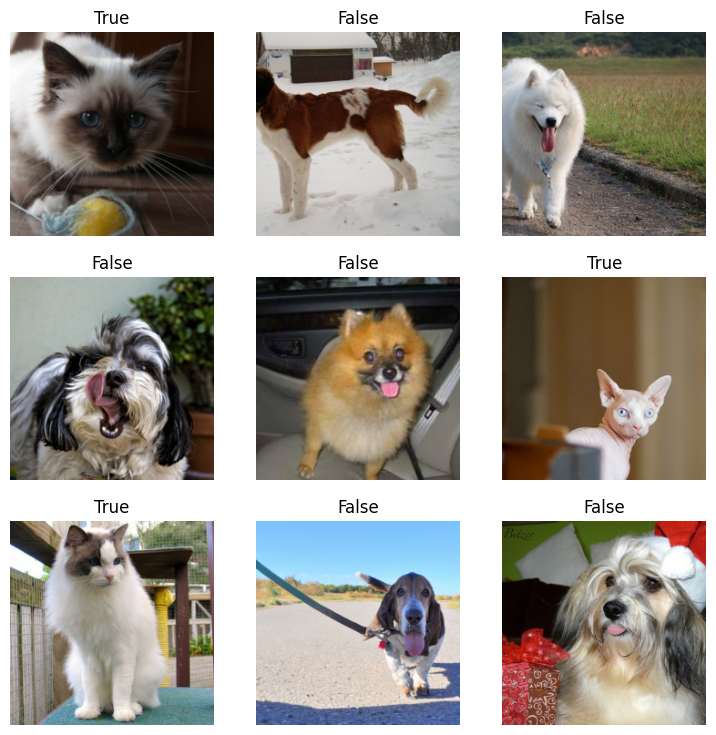

In [39]:
dls.show_batch()

Finally we will train a ResNet model for classification, and see the results.

In [40]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

The `show_results()` randomly shows some of the predictions.

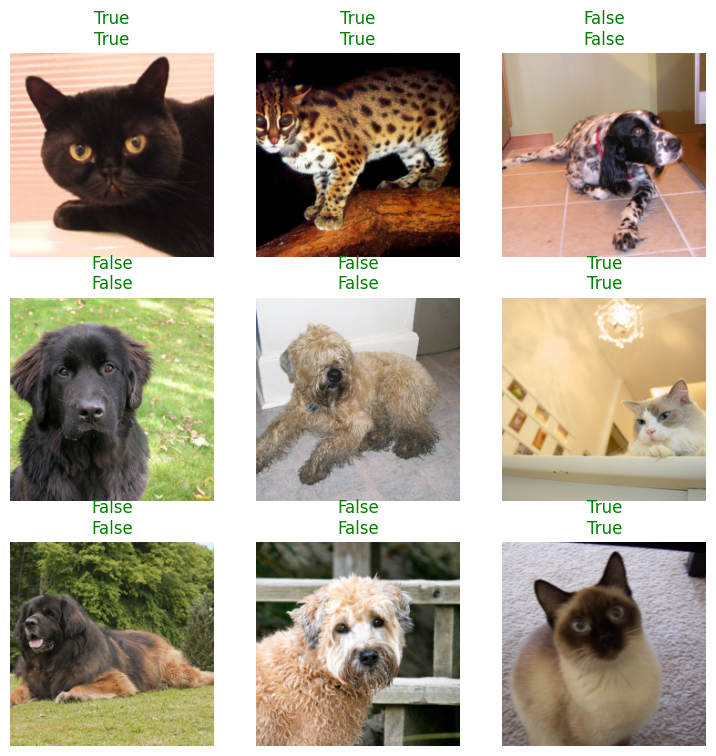

In [41]:
learn.show_results()

The `Interpretation` object can show where the model made most errors.

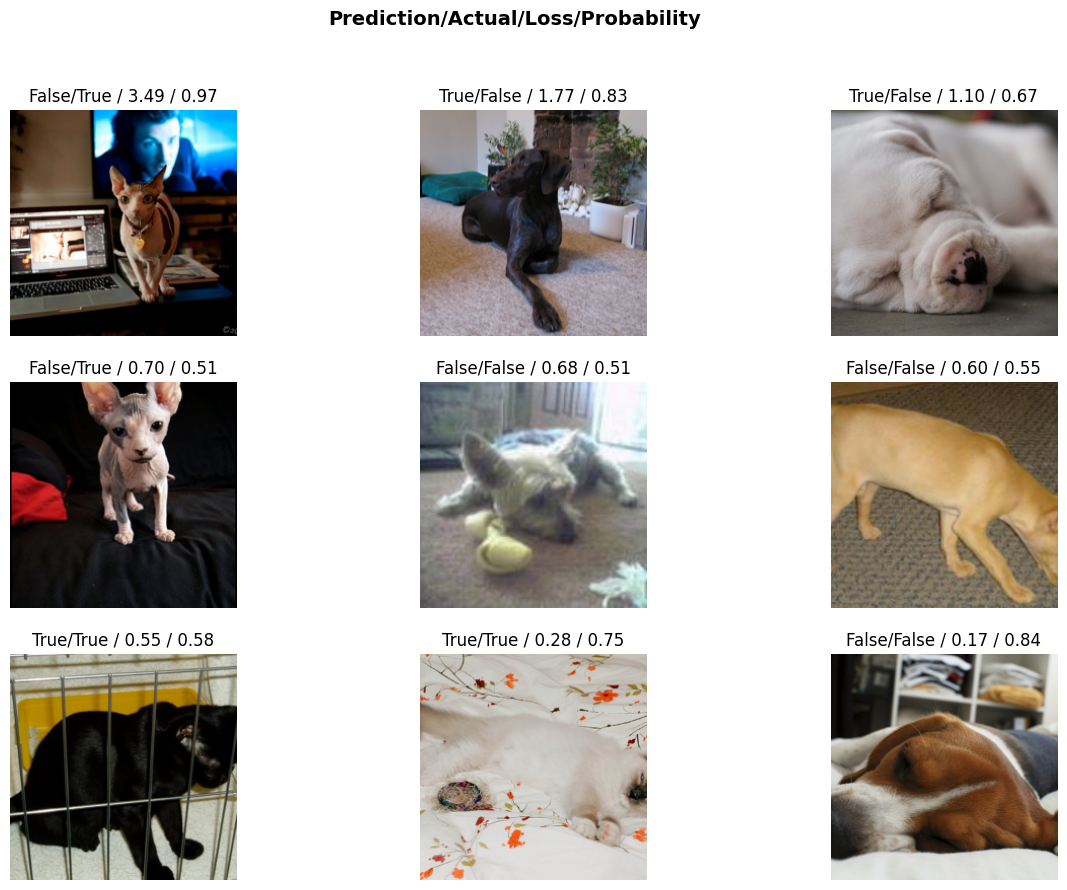

In [42]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15, 10))

We can also extract the breed name using regular expression. At the same time we will also use data augmentation using the `batch_tfms` parameter. `aug_transforms` supplies some common augementation techniques that are well suited to most datasets.

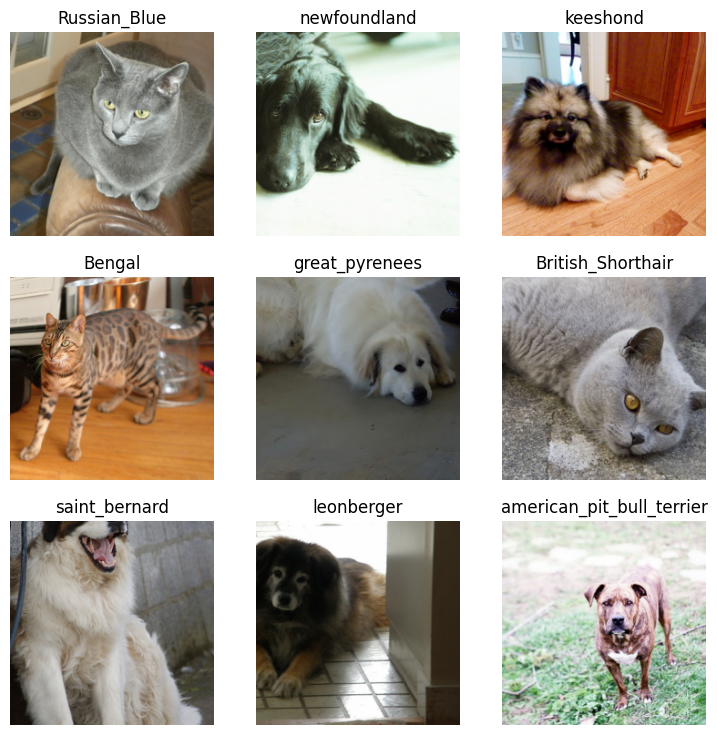

In [43]:
pattern = r'^(.*)_\d+.jpg'
dls = ImageDataLoaders.from_name_re(path, files, pattern, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))
dls.show_batch()

### The DataBlock API

A datablock is built by giving the fastai library a bunch of informations:

- The types used, through an argument called `blocks`: here we have images and categories, so we pass `ImageBlock` and `CategoryBlock`.
- How to get the raw items, here our function `get_image_files`.
- how to label those items, here with the same regular expression as before.
- how to split those items, here with a random splitter.
- the `item_tfms` and `batch_tfms` like before.

In [44]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

The `pets` data block is empty initially. To actually load the data, we have to call the `dataloaders` method.

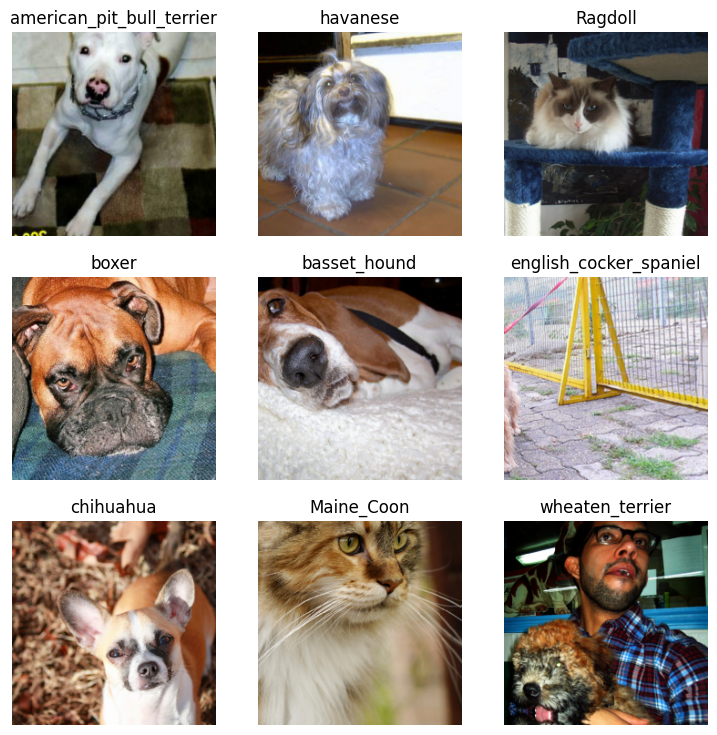

In [45]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)